In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV,KFold,RandomizedSearchCV,StratifiedKFold,train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import pandas_profiling as pp

In [77]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_bqCt9Pv.csv')

In [78]:
test['loan_default']=np.NAN

In [79]:
df = pd.concat([train,test])
#df.reset_index(inplace=True,drop=True)

In [80]:
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1.0
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0.0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1.0
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1.0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345546 entries, 0 to 112391
Data columns (total 41 columns):
UniqueID                               345546 non-null int64
disbursed_amount                       345546 non-null int64
asset_cost                             345546 non-null int64
ltv                                    345546 non-null float64
branch_id                              345546 non-null int64
supplier_id                            345546 non-null int64
manufacturer_id                        345546 non-null int64
Current_pincode_ID                     345546 non-null int64
Date.of.Birth                          345546 non-null object
Employment.Type                        334442 non-null object
DisbursalDate                          345546 non-null object
State_ID                               345546 non-null int64
Employee_code_ID                       345546 non-null int64
MobileNo_Avl_Flag                      345546 non-null int64
Aadhar_flag                   

In [7]:
pp.ProfileReport(df)

Number of variables,42
Number of observations,345546
Total Missing (%),0.9%
Total size in memory,110.7 MiB
Average record size in memory,336.0 B
Numeric,28
Categorical,6
Boolean,5
Date,0
Text (Unique),0
Rejected,3


In [82]:
df.columns = df.columns.str.replace('.','_')

In [83]:
df.Employment_Type=df.groupby(['State_ID'])['Employment_Type'].transform(lambda x: x.fillna(x.mode()[0]))

In [84]:
import datetime as dt 
df['Age']=np.floor(abs((dt.datetime.now()-pd.DatetimeIndex(df.Date_of_Birth)).days/365))
df['LoanAge']=abs((dt.datetime.now()-pd.DatetimeIndex(df.DisbursalDate)).days)

In [85]:
df.drop(columns=['Date_of_Birth'],inplace=True)
df.drop(columns=['DisbursalDate'],inplace=True)

In [86]:
sc = StandardScaler()

In [87]:
df[['Avg_acc_yr','Avg_acc_mon']]=df.AVERAGE_ACCT_AGE.str.extract(r'(\d*)\w*\s(\d*)',expand=True)

In [88]:
df.drop(columns='AVERAGE_ACCT_AGE',inplace=True)

In [89]:
df[['Credit_Hist_yr','Credit_Hist_mon']]=df.CREDIT_HISTORY_LENGTH.str.extract(r'(\d*)\w*\s(\d*)',expand=True)

In [90]:
df.drop(columns='CREDIT_HISTORY_LENGTH',inplace=True)

In [91]:
df['Avg_Acc_Age']=(df.Avg_acc_yr+'.'+df.Avg_acc_mon).apply(lambda x: float(x))
df['CREDIT_HISTORY_Age']=(df.Credit_Hist_yr+'.'+df.Credit_Hist_mon).apply(lambda x: float(x))

In [92]:
df.drop(columns=['Avg_acc_yr','Avg_acc_mon','Credit_Hist_yr','Credit_Hist_mon','PERFORM_CNS_SCORE_DESCRIPTION','UniqueID'],inplace=True)

In [93]:
final=pd.concat([df,pd.get_dummies(df.Employment_Type)],axis=1)

In [94]:
final.drop(columns = 'Employment_Type',inplace=True)

In [95]:
tr = final[~final.loan_default.isna()]
ts = final[final.loan_default.isna()]

In [96]:
tst = ts.drop(columns='loan_default')

In [97]:
x = tr.drop(columns='loan_default')
y = tr['loan_default']

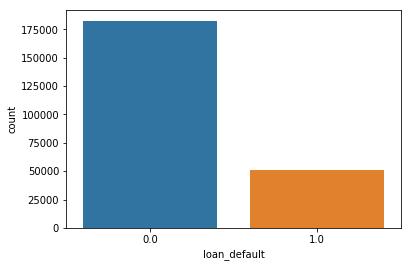

In [98]:
%matplotlib inline
sns.countplot(y)

In [99]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3)

In [100]:
p_lr=Pipeline([('sc',sc),('lr',LogisticRegression(n_jobs=-1))])
p_lr1=Pipeline([('sc1',sc),('lr1',LogisticRegression(penalty='l1',n_jobs=-1))])
p_rd=Pipeline([('sc',sc),('rd',RidgeClassifier())])
p_rf = Pipeline([('rf',RandomForestClassifier(n_jobs=-1))])
p_dt = Pipeline([('DT',DecisionTreeClassifier())])

In [101]:
grid_lr={'lr__class_weight':['balanced',None]}
grid_lr1={'lr1__class_weight':['balanced']}
grid_rd={'rd__normalize':[True,False]}
#grid_rf = {'rf__class_weight':['balanced',None],'rf__criterion':['gini','entropy'],'rf__n_estimators':[51,101,151],'rf__max_depth':[10,20,30],'rf__max_features':[None,'log2'],'rf__min_samples_split':[2,6,8],'rf__min_samples_leaf':[1,5,7]}
grid_rf = {'rf__class_weight':['balanced',None],'rf__criterion':['gini'],'rf__n_estimators':[301,201,101],'rf__max_depth':[10,20,30],'rf__min_samples_split':[4,6,8],'rf__min_samples_leaf':[2,5,7]}
grid_dt = {'dt__class_weight':['balanced',None],'dt__criterion':['gini','entropy'],'dt__min_samples_split':[2,6],'dt__min_samples_leaf':[1,5]}

In [102]:
cv =StratifiedKFold(n_splits=6).get_n_splits(x,y)

In [103]:
lr =GridSearchCV(p_lr,grid_lr,scoring='roc_auc',cv=cv,verbose=True)
lr1 =GridSearchCV(p_lr1,grid_lr1,scoring='roc_auc',cv=cv,verbose=True)
rd=GridSearchCV(p_rd,grid_rd,scoring='roc_auc',cv=cv,verbose=True)
rf=RandomizedSearchCV(p_rf,grid_rf,scoring='roc_auc',cv=cv,verbose=True)
dt=GridSearchCV(p_dt,grid_dt,scoring='roc_auc',cv=cv)

In [104]:
#model=[lr,lr1,rd]
model=[rf]
modelname=['LR','Lass','Rif','RF']

In [132]:
ypred=pd.DataFrame()
for j,i in enumerate(model):
    i.fit(x_train,y_train)
    k=i.predict(x_test)
    ypred[modelname[j]] = k
    print(roc_auc_score(y_test,k))
    print(i.best_params_)
    print(i.best_score_)

Fitting 6 folds for each of 10 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 52.4min finished


0.5051493656736885
{'rf__n_estimators': 201, 'rf__min_samples_split': 8, 'rf__min_samples_leaf': 5, 'rf__max_depth': 30, 'rf__criterion': 'gini', 'rf__class_weight': None}
0.6566626446382391


ypred=pd.DataFrame()
for j,i in enumerate(model):
    i.fit(x_train,y_train)
    k=i.predict(x_test)
    ypred[modelname[j]] = k
    print(roc_auc_score(y_test,k))
    print(i.best_params_)
    print(i.best_score_)

In [135]:
modl = RandomForestClassifier(n_estimators=301,max_depth=20,min_samples_split=6,min_samples_leaf=5,verbose=True)
modl.fit(x_train,y_train)
k = modl.predict(x_test)
print(roc_auc_score(y_test,k))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.5039851011293007


[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    6.9s finished


In [136]:
rfpred = modl.predict(tst)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:    9.3s finished


In [122]:
out=pd.concat([test.UniqueID,pd.Series(k)],axis=1)
out.columns=['UniqueID','loan_default']


In [137]:
Final=test[["UniqueID","loan_default"]]

In [138]:
Final["loan_default"]=rfpred

C:\Users\VINOTH S\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [142]:
Final.head()

,UniqueID,loan_default
0,655269,0.0
1,723482,0.0
2,758529,0.0
3,763449,0.0
4,708663,0.0


In [139]:
out.loan_default=Final.loan_default.astype(np.int)

In [140]:
out.loan_default.value_counts()

0    112203
1       189
Name: loan_default, dtype: int64

In [141]:
out.to_csv('LTFSPred.csv',index=False)

In [143]:
from sklearn.ensemble import AdaBoostClassifier
adabst_fit = AdaBoostClassifier(base_estimator= modl,
        n_estimators=300,learning_rate=0.05,random_state=42)

In [144]:
adabst_fit.fit(x_train,y_train)
k = adabst_fit.predict(x_test)
print(roc_auc_score(y_test,k))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:   17.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:   16.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:   16.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

KeyboardInterrupt: 

In [145]:
rfpred = adabst_fit.predict(tst)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:   35.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:   25.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 301 out of 301 | elapsed:   30.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [146]:
Final=test[["UniqueID","loan_default"]]

In [147]:
Final["loan_default"]=rfpred

C:\Users\VINOTH S\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [148]:
out.loan_default=Final.loan_default.astype(np.int)

In [149]:
out.loan_default.value_counts()

0    112203
1       189
Name: loan_default, dtype: int64